In [12]:
import pandas as pd
import numpy as np
import os
import sys

sys.path.append("../../../../")
from analysis_functions import *

In [13]:
# Загрузка данных
X_stress_components_new = opener(
    "X_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
X_strain_components_new = opener(
    "X_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
y_stress_components_new = opener(
    "y_stress_components_new_components",
    path_import="../../../../new_components_resources",
)
y_strain_components_new = opener(
    "y_strain_components_new_components",
    path_import="../../../../new_components_resources",
)
# X_stress_components_other = opener('X_stress_components_other')
# X_strain_components_other = opener('X_strain_components_other')
# y_stress_components_other = opener('y_stress_components_other')
# y_strain_components_other = opener('y_strain_components_other')


../../../../new_components_resources/X_stress_components_new_components.pkl
../../../../new_components_resources/X_strain_components_new_components.pkl
../../../../new_components_resources/y_stress_components_new_components.pkl
../../../../new_components_resources/y_strain_components_new_components.pkl


In [14]:
component_num = 1

X, y = (X_stress_components_new[component_num], 
        y_stress_components_new[component_num])

## Простое обучение

In [15]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Разделение данных на обучающую, валидационную и тестовую выборки
cur_X_train, cur_X_test, cur_y_train, cur_y_test = split_transform_one_comp_train_test(
    X, y
)

# Обучение модели
model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    loss="squared_error",
    random_state=RANDOM_STATE,
)
model.fit(cur_X_train, cur_y_train)

# Предсказание
cur_y_pred = model.predict(cur_X_test)

# Оценка качества
rmse = np.sqrt(mean_squared_error(cur_y_test, cur_y_pred))
print(f"RMSE test: {rmse:.2f}")

# На трейне
cur_y_pred_train = model.predict(cur_X_train)
rmse_train = np.sqrt(mean_squared_error(cur_y_train, cur_y_pred_train))
print(f"RMSE train: {rmse_train:.2f}")


RMSE test: 17.97
RMSE train: 17.99


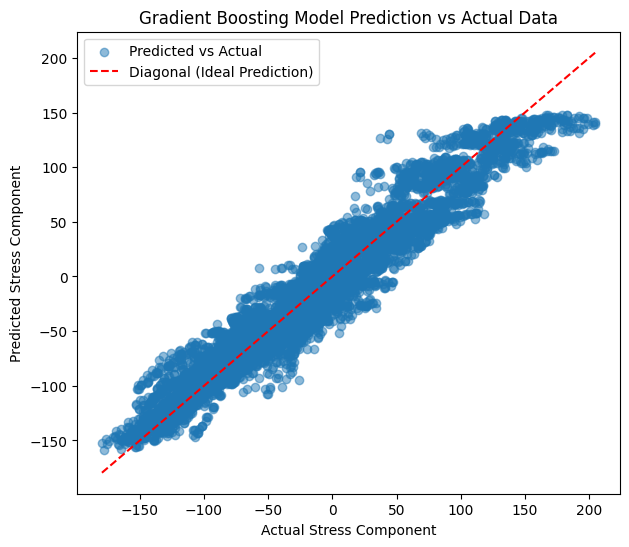

In [16]:
import matplotlib.pyplot as plt

# Predicting the values
cur_y_pred = model.predict(cur_X_test)

# Plotting the results
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, cur_y_pred, alpha=0.5, label="Predicted vs Actual")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Diagonal (Ideal Prediction)",
)
plt.xlabel("Actual Stress Component")
plt.ylabel("Predicted Stress Component")
plt.title("Gradient Boosting Model Prediction vs Actual Data")
plt.legend()
plt.show()

## С оптимизацией гиперпараметров

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score

n_splits = 5
# Preparing datasets
cur_X_test, cur_y_test, val_list_X, val_list_y, train_list_X, train_list_y = (
    split_transform_one_comp_cv(X, y, n_splits=n_splits)
)

def do_optuna_for_boosting(X, y, n_trials=200, **kwargs):
    n_splits = kwargs.get("n_splits", 3)

    def optuna_boosting_val(trial):
        n_estimators = trial.suggest_int("n_estimators", 50, 300)
        max_depth = trial.suggest_int("max_depth", 1, 10)
        learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True)

        params = {
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "random_state": RANDOM_STATE,
        }

        # Fitting and scoring `n_split` times
        errors = np.zeros((n_splits, 9))

        for split_idx in range(n_splits):
            regr = GradientBoostingRegressor(**params)

            cur_X_train = train_list_X[split_idx]
            cur_y_train = train_list_y[split_idx]

            cur_X_val = val_list_X[split_idx]
            cur_y_val = val_list_y[split_idx]

            cur_X_train, cur_y_train = clean_input_array(cur_X_train, cur_y_train)
            cur_X_val, cur_y_val = clean_input_array(cur_X_val, cur_y_val)

            regr.fit(cur_X_train, cur_y_train)

            #######  Validation  ########
            #  Prediction
            cur_prediction = regr.predict(cur_X_val)
            # Scoring
            errors[split_idx] = scorer(cur_y_val, cur_prediction, regr, cur_X_train)

        # Collect validation result
        val_metrics = choose_worst(errors)
        return_value = (
            val_metrics[-1] if pd.notnull(val_metrics[-1]) else +1e6
        )  # для rmse
        return return_value

    # Create a study object to optimize the objective
    study = optuna.create_study(direction="minimize")  # rmse
    study.optimize(optuna_boosting_val, n_trials=n_trials, n_jobs=-1)

    # Print the best hyperparameters found by Optuna
    best_params = study.best_params
    best_value = study.best_value
    print("Best Hyperparameters:", best_params)

    return best_params, cur_X_test, cur_y_test, best_value

# Use the function
best_params, cur_X_test, cur_y_test, best_value = do_optuna_for_boosting(X, y, n_splits=n_splits)

# Предсказание
model = GradientBoostingRegressor(**best_params, random_state=RANDOM_STATE)
model.fit(cur_X_train, cur_y_train)
cur_y_pred = model.predict(cur_X_test)

# Оценка качества
rmse = np.sqrt(mean_squared_error(cur_y_test, cur_y_pred))
print(f"RMSE test: {rmse:.2f}")

# На трейне
cur_y_pred_train = model.predict(cur_X_train)
rmse_train = np.sqrt(mean_squared_error(cur_y_train, cur_y_pred_train))
print(f"RMSE train: {rmse_train:.2f}")

[I 2025-05-16 15:41:04,767] A new study created in memory with name: no-name-c08df233-006a-488d-8628-28fcf34922eb
[I 2025-05-16 15:41:06,080] Trial 4 finished with value: 63.499762552756025 and parameters: {'n_estimators': 58, 'max_depth': 1, 'learning_rate': 0.0037765753964758932}. Best is trial 4 with value: 63.499762552756025.
[I 2025-05-16 15:41:09,611] Trial 6 finished with value: 60.815270747195214 and parameters: {'n_estimators': 76, 'max_depth': 4, 'learning_rate': 0.0022084072620129503}. Best is trial 6 with value: 60.815270747195214.
[I 2025-05-16 15:41:12,409] Trial 5 finished with value: 12.243697941185118 and parameters: {'n_estimators': 81, 'max_depth': 7, 'learning_rate': 0.04298233491842804}. Best is trial 5 with value: 12.243697941185118.
[I 2025-05-16 15:41:13,123] Trial 1 finished with value: 25.268296908021004 and parameters: {'n_estimators': 136, 'max_depth': 4, 'learning_rate': 0.012291365901538127}. Best is trial 5 with value: 12.243697941185118.
[I 2025-05-16 15

Best Hyperparameters: {'n_estimators': 157, 'max_depth': 10, 'learning_rate': 0.05077010039032203}
RMSE test: 6.40
RMSE train: 2.96


In [18]:
import joblib

# Best Hyperparameters: {'n_estimators': 254, 'max_depth': 10, 'learning_rate': 0.07123668319491888}
# best_params = {'n_estimators': 254, 'max_depth': 10, 'learning_rate': 0.07123668319491888}
# Train the model with the best hyperparameters
model = GradientBoostingRegressor(**best_params, random_state=RANDOM_STATE)
cur_X_train = train_list_X[-1]
cur_y_train = train_list_y[-1]
model.fit(cur_X_train, cur_y_train)

pred = model.predict(cur_X_test)
rmse = np.sqrt(mean_squared_error(cur_y_test, pred))
print(f"RMSE Test: {rmse:.2f}")


print(f"RMSE Train: {rmse:.2f}")
mse_best = mean_squared_error(cur_y_test, pred)
print(f"MSE test with best model: {mse_best:.2f}")
mae_best = mean_absolute_error(cur_y_test, pred)
print(f"MAE test with best model: {mae_best:.2f}")
r2_best = r2_score(cur_y_test, pred)
print(f"R2 test with best model: {r2_best:.2f}")

pred_train = model.predict(cur_X_train)
rmse = np.sqrt(mean_squared_error(cur_y_train, pred_train))


# Save the model to a file
model_filename = "best_gradient_boosting_model.pkl"
joblib.dump(model, model_filename)
print(f"Model saved to {model_filename}")


RMSE Test: 6.69
RMSE Train: 6.69
MSE test with best model: 44.82
MAE test with best model: 3.77
R2 test with best model: 0.99
Model saved to best_gradient_boosting_model.pkl


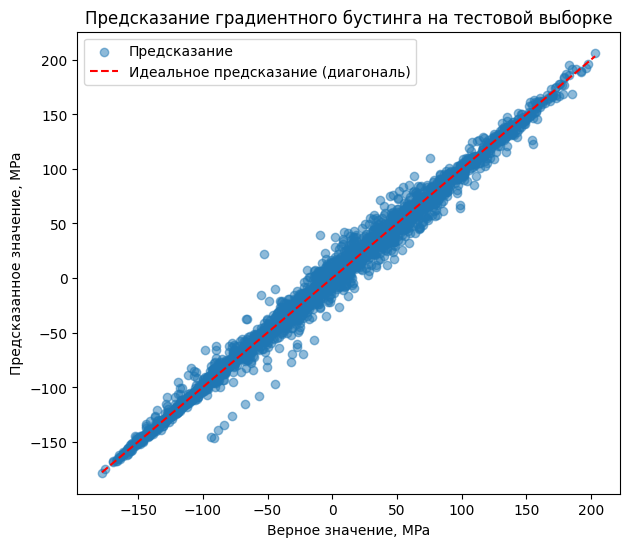

In [19]:
import matplotlib.pyplot as plt

# Plotting the results using the best model
plt.figure(figsize=(7, 6))
plt.scatter(cur_y_test, pred, alpha=0.5, label="Предсказание")
plt.plot(
    [min(cur_y_test), max(cur_y_test)],
    [min(cur_y_test), max(cur_y_test)],
    color="red",
    linestyle="--",
    label="Идеальное предсказание (диагональ)",
)
plt.xlabel("Верное значение, MPa")
plt.ylabel("Предсказанное значение, MPa")
plt.title("Предсказание градиентного бустинга на тестовой выборке")
plt.legend()
plt.savefig(f"best_gradient_boosting_prediction_{component_num}.png", dpi=400)
plt.show()


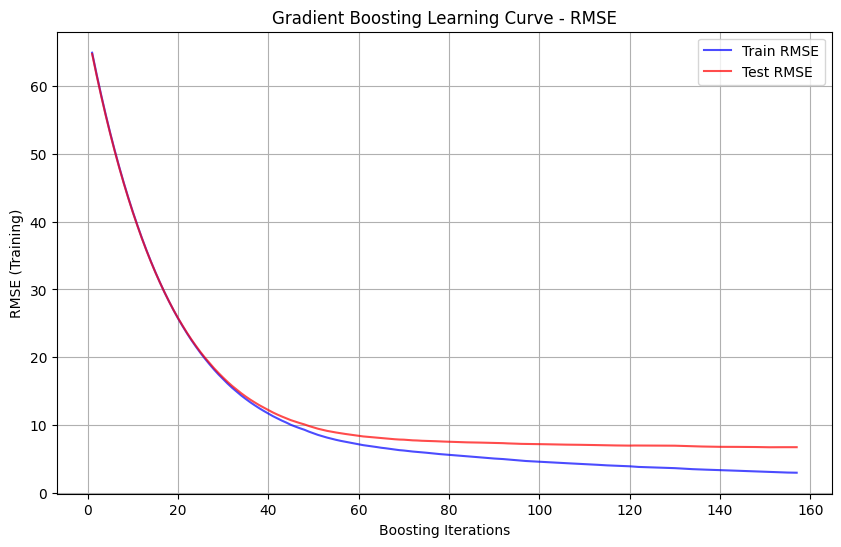

In [20]:
# Построение кривой обучения из градиентного бустинга
import matplotlib.pyplot as plt
import numpy as np

# Извлечение ошибок обучения на каждой итерации
train_scores = model.train_score_

# Преобразование значений train_score в MSE
# В GradientBoostingRegressor train_score_ содержит значения функции потерь со знаком минус
# для squared_error это половина MSE, поэтому умножаем на -2
train_mse_scores = np.array(train_scores)

# Вычисление RMSE для тренировочных данных
train_rmse_scores = np.sqrt(train_mse_scores)

# Вычисляем тестовую ошибку на каждой итерации
test_mse_scores = []
test_rmse_scores = []

# Используем staged_predict для получения предсказаний на каждой итерации
for y_pred in model.staged_predict(cur_X_test):
    test_mse = mean_squared_error(cur_y_test, y_pred)
    test_mse_scores.append(test_mse)
    test_rmse_scores.append(np.sqrt(test_mse))

# Создание массива с номерами итераций
iterations = np.arange(len(train_scores)) + 1

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(iterations, train_rmse_scores, 'b-', label='Train RMSE', alpha=0.7)
plt.plot(iterations, test_rmse_scores, 'r-', label='Test RMSE', alpha=0.7)
plt.xlabel('Boosting Iterations')
plt.ylabel('RMSE (Training)')
plt.title('Gradient Boosting Learning Curve - RMSE')
plt.legend()
plt.grid(True)
plt.show()

Оптимальное количество деревьев: 157
Минимальная ошибка RMSE на валидации: 5.5912


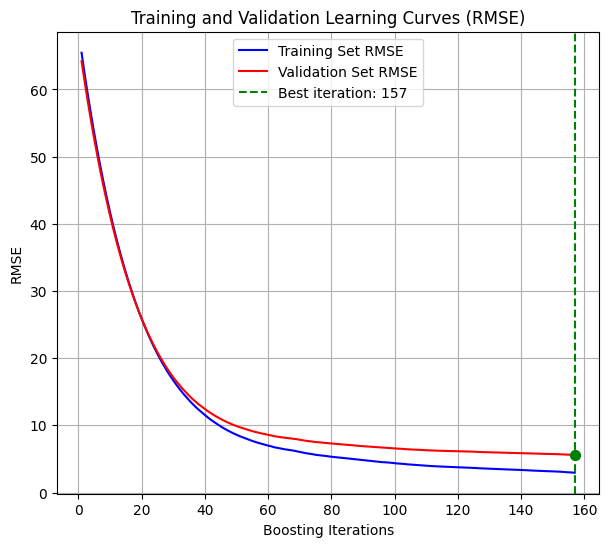

In [21]:
# Более детальный анализ кривой обучения с валидационной выборкой
from sklearn.model_selection import train_test_split

# Разделим данные на обучающую и валидационную выборку
X_train, X_val, y_train, y_val = train_test_split(
    cur_X_train, cur_y_train, test_size=0.2, random_state=RANDOM_STATE
)

# Создаем модель с теми же параметрами
val_model = GradientBoostingRegressor(
    **best_params,
    random_state=RANDOM_STATE,
    validation_fraction=0.2,  # 20% данных используем для валидации
    n_iter_no_change=10,  # Раннее останавливание если нет улучшения 10 итераций
    verbose=0
)

# Обучаем модель на тренировочных данных
val_model.fit(X_train, y_train)

# Получаем оценки на каждой итерации
train_scores = val_model.train_score_

# Вычисляем ошибки для валидационной выборки на каждой итерации
val_mse_scores = []

for i, y_pred in enumerate(val_model.staged_predict(X_val)):
    val_mse_scores.append(mean_squared_error(y_val, y_pred))

# Преобразование тренировочных ошибок в MSE
train_mse_scores = np.array(train_scores)

# Преобразование в RMSE
train_rmse_scores = np.sqrt(train_mse_scores)
val_rmse_scores = np.sqrt(np.array(val_mse_scores))

# Построение графика
plt.figure(figsize=(7, 6))
plt.plot(np.arange(1, len(train_rmse_scores) + 1), train_rmse_scores, 'b-',
         label='Training Set RMSE')
plt.plot(np.arange(1, len(val_rmse_scores) + 1), val_rmse_scores, 'r-',
         label='Validation Set RMSE')
plt.xlabel('Boosting Iterations')
plt.ylabel('RMSE')
plt.title('Training and Validation Learning Curves (RMSE)')
plt.legend()
plt.grid(True)

# Найдем оптимальное количество итераций на основе валидационной ошибки
best_iter = np.argmin(val_rmse_scores) + 1
min_val_rmse = np.min(val_rmse_scores)
plt.axvline(x=best_iter, color='green', linestyle='--',
            label=f'Best iteration: {best_iter}')
plt.scatter(best_iter, min_val_rmse, color='green', s=50, zorder=10)
plt.legend()

print(f"Оптимальное количество деревьев: {best_iter}")
print(f"Минимальная ошибка RMSE на валидации: {min_val_rmse:.4f}")
plt.show()